## First, get the data into a useful format

In [2]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
from math import sqrt
import matplotlib.pyplot as plt

In [3]:
# Read in datafiles
gfs = pd.read_csv('./raw_data/GFS_Daily_PredictVars_2010thru2019.csv', index_col = 'Date', usecols = ['Date', 'TMAX', 'TMIN', 'WMAX', 'RTOT'], parse_dates = True)
# gfsfs = pd.read_csv('./raw_data/GFS_Sfc_42hrFcst_2010thru2019.csv', skiprows=1, index_col = 'Date', parse_dates = True)
hourly = pd.read_csv('./raw_data/KCMI_hourly_tidy.csv', index_col = 'Timestamp', parse_dates = True)
hourly.index = hourly.index + pd.DateOffset(hours=12)  # Align times

obs = pd.read_csv('./raw_data/KCMI_daily_tidy.csv', index_col = 'Date', parse_dates = True)
obs.index = obs.index + pd.DateOffset(hours=12)  # Align times

sfc = pd.read_csv('./raw_data/GFS_Sfc_06Zto06ZAvgMinMax_AdditionalVars_2010thru2019.csv',  index_col = 'Unnamed: 0', parse_dates = True)
sfc.index = sfc.index + pd.DateOffset(days=1)  # Align times
prof = pd.read_csv('./raw_data/GFS_Prof_06Zto06ZAvgMinMax_2010thru2019.csv',  index_col = 'Unnamed: 0', parse_dates = True)
prof.index = prof.index + pd.DateOffset(days=1)  # Align times

In [5]:
# There is some missing data from the GFS forecasts!
print(gfs.shape)
print(hourly.shape)
print(obs.shape)
print(sfc.shape)
print(prof.shape)

(3614, 4)
(3652, 7)
(3652, 4)
(3652, 15)
(3652, 24)


In [6]:
# Merge and drop all days with missing values 
features = pd.merge(obs.reset_index().dropna(), gfs.reset_index(), on = 'Date', how = 'inner')
features = pd.merge(features, hourly.reset_index(), left_on = 'Date', right_on = 'Timestamp', how = 'inner').drop(columns = 'Timestamp')
features = pd.merge(features, prof.reset_index(), left_on = 'Date', right_on = 'index', how = 'inner').drop(columns = 'index')
features = pd.merge(features, sfc.reset_index(), left_on = 'Date', right_on = 'index', how = 'inner').drop(columns = 'index')
features.dropna(inplace = True)  # There are some NaNs in the observations

In [7]:
features.describe()

,Max Hourly Temp (C),Min Hourly Temp (C),Max Wind Speed (m/s),Daily Precip (mm),TMAX,TMIN,WMAX,RTOT,tmpc,dwpc,...,Max LCLD(%),Avg MCLD(%),Min MCLD(%),Max MCLD(%),Avg HCLD(%),Min HCLD(%),Max HCLD(%),Avg PRES(hPa),Min PRES(hPa),Max PRES(hPa)
count,3235.000000,3235.000000,3235.000000,3235.000000,3235.000000,3235.000000,3235.000000,3235.000000,3235.000000,3235.000000,...,3235.000000,3235.000000,3235.000000,3235.000000,3235.000000,3235.000000,3235.000000,3235.000000,3235.000000,3235.000000
mean,17.569981,6.536321,7.602858,2.039505,16.126090,7.182195,5.774674,3.312745,13.890460,6.835838,...,46.454096,17.334272,1.129521,47.128594,36.448324,9.004946,69.883462,989.379948,986.436043,992.189026
std,11.909521,10.794822,2.932900,5.948541,11.217239,10.014249,2.350140,7.023797,11.962511,10.990492,...,42.995764,21.560567,7.481388,42.549424,30.265066,21.719197,37.625728,6.110867,6.583452,6.056750
min,-21.111111,-26.666667,2.235200,0.000000,-18.760000,-25.060000,1.431782,0.000000,-23.366667,-28.575000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,962.566667,954.800000,970.300000
25%,8.333333,-1.111111,5.811520,0.000000,7.140000,-0.560000,4.001250,0.000000,4.379167,-1.425000,...,0.000000,0.000000,0.000000,0.000000,7.833333,0.000000,41.000000,985.661111,982.800000,988.200000
50%,20.000000,7.777778,7.152640,0.000000,18.140000,8.440000,5.393515,0.310000,16.008333,7.400000,...,38.000000,7.666667,0.000000,46.000000,32.666667,0.000000,92.000000,989.155556,986.800000,991.600000
75%,27.777778,16.111111,9.387840,0.350000,25.940000,15.540000,7.182618,3.320000,24.441667,16.379167,...,96.000000,28.666667,0.000000,96.000000,60.000000,1.000000,100.000000,992.966667,990.400000,995.800000
max,37.777778,25.555556,23.246080,85.900000,37.140000,25.040000,16.413714,81.010000,34.716667,26.391667,...,101.000000,100.000000,100.000000,101.000000,100.000000,100.000000,101.000000,1012.800000,1010.400000,1016.400000


In [8]:
# Add year, month, day as integers 
features['year'] = features['Date'].dt.year
features['month'] = features['Date'].dt.month
features['day'] = features['Date'].dt.day

In [9]:
# The data we will be using to predict the labels
new_features = features.drop(columns = ['Date', 'Max Hourly Temp (C)', 'Min Hourly Temp (C)', 'Max Wind Speed (m/s)', 'Daily Precip (mm)'], axis = 1)

# Save feature list for later
feature_list = list(new_features.columns)

In [267]:
feature_list

['TMAX',
 'TMIN',
 'WMAX',
 'RTOT',
 'tmpc',
 'dwpc',
 'mslp',
 'wdir',
 'wspd',
 'skct',
 'pr1h',
 'Avg 850hPa DWPDEP(C)',
 'Min 850hPa DWPDEP(C)',
 'Max 850hPa DWPDEP(C)',
 'Avg 925hPa DWPDEP(C)',
 'Min 925hPa DWPDEP(C)',
 'Max 925hPa DWPDEP(C)',
 'Avg 250hPa HGT(m)',
 'Min 250hPa HGT(m)',
 'Max 250hPa HGT(m)',
 'Avg 500hPa HGT(m)',
 'Min 500hPa HGT(m)',
 'Max 500hPa HGT(m)',
 'Min 850hPa TMPC',
 'Max 850hPa TMPC',
 'Min 925hPa TMPC',
 'Max 925hPa TMPC',
 'Min 250hPa WSPD(m/s)',
 'Max 250hPa WSPD(m/s)',
 'Min 500hPa WSPD(m/s)',
 'Max 500hPa WSPD(m/s)',
 'Min 850hPa WSPD(m/s)',
 'Max 850hPa WSPD(m/s)',
 'Min 925hPa WSPD(m/s)',
 'Max 925hPa WSPD(m/s)',
 'Avg DWPDEP(C)',
 'Min DWPDEP(C)',
 'Max DWPDEP(C)',
 'Avg LCLD(%)',
 'Min LCLD(%)',
 'Max LCLD(%)',
 'Avg MCLD(%)',
 'Min MCLD(%)',
 'Max MCLD(%)',
 'Avg HCLD(%)',
 'Min HCLD(%)',
 'Max HCLD(%)',
 'Avg PRES(hPa)',
 'Min PRES(hPa)',
 'Max PRES(hPa)',
 'year',
 'month',
 'day']

## Now run the model!

### Maximum Temperature

In [10]:
# Split the data into training and testing sets
train_features = np.array(new_features.query('year < 2019'))
test_features = np.array(new_features.query('year == 2019'))
train_labels = np.array(features.query('year < 2019')['Max Hourly Temp (C)'])
test_labels = np.array(features.query('year == 2019')['Max Hourly Temp (C)'])

In [11]:
# Check if any NaNs exist
new_features.query('year < 2019').isna().sum()

TMAX                    0
TMIN                    0
WMAX                    0
RTOT                    0
tmpc                    0
dwpc                    0
mslp                    0
wdir                    0
wspd                    0
skct                    0
pr1h                    0
Avg 850hPa DWPDEP(C)    0
Min 850hPa DWPDEP(C)    0
Max 850hPa DWPDEP(C)    0
Avg 925hPa DWPDEP(C)    0
Min 925hPa DWPDEP(C)    0
Max 925hPa DWPDEP(C)    0
Avg 250hPa HGT(m)       0
Min 250hPa HGT(m)       0
Max 250hPa HGT(m)       0
Avg 500hPa HGT(m)       0
Min 500hPa HGT(m)       0
Max 500hPa HGT(m)       0
Min 850hPa TMPC         0
Max 850hPa TMPC         0
Min 925hPa TMPC         0
Max 925hPa TMPC         0
Min 250hPa WSPD(m/s)    0
Max 250hPa WSPD(m/s)    0
Min 500hPa WSPD(m/s)    0
Max 500hPa WSPD(m/s)    0
Min 850hPa WSPD(m/s)    0
Max 850hPa WSPD(m/s)    0
Min 925hPa WSPD(m/s)    0
Max 925hPa WSPD(m/s)    0
Avg DWPDEP(C)           0
Min DWPDEP(C)           0
Max DWPDEP(C)           0
Avg LCLD(%) 

In [12]:
# Check if any NaNs exist
features.query('year == 2019')['Max Hourly Temp (C)'].isna().sum()

0

In [13]:
# Let's check how well the GFS forecast does. This will be our 'base prediction'
print('Root Mean Square Error:', round(sqrt(mean_squared_error(test_labels, new_features.query('year == 2019')['TMAX'].values)), 2), 'degrees C.')

Root Mean Square Error: 4.51 degrees C.


In [14]:
print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)

Training Features Shape: (2928, 53)
Training Labels Shape: (2928,)
Testing Features Shape: (307, 53)
Testing Labels Shape: (307,)


In [15]:
# Import the model we are using
from sklearn.ensemble import RandomForestRegressor

# Instantiate model with 1000 decision trees
rfmax = RandomForestRegressor(n_estimators = 1000, random_state = 42)

# Train the model on training data
rfmax.fit(train_features, train_labels);

In [16]:
# Use the forest's predict method on the test data
predictions = rfmax.predict(test_features)

# Print out the root mean square error (rmse)
print('Root Mean Square Error:', round(sqrt(mean_squared_error(test_labels, predictions)), 2), 'degrees C.')

Root Mean Square Error: 2.04 degrees C.


In [17]:
# Get numerical feature importances
importances = list(rfmax.feature_importances_)

# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]

# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: Max 925hPa TMPC      Importance: 0.63
Variable: Min 925hPa TMPC      Importance: 0.31
Variable: TMAX                 Importance: 0.01
Variable: tmpc                 Importance: 0.01
Variable: TMIN                 Importance: 0.0
Variable: WMAX                 Importance: 0.0
Variable: RTOT                 Importance: 0.0
Variable: dwpc                 Importance: 0.0
Variable: mslp                 Importance: 0.0
Variable: wdir                 Importance: 0.0
Variable: wspd                 Importance: 0.0
Variable: skct                 Importance: 0.0
Variable: pr1h                 Importance: 0.0
Variable: Avg 850hPa DWPDEP(C) Importance: 0.0
Variable: Min 850hPa DWPDEP(C) Importance: 0.0
Variable: Max 850hPa DWPDEP(C) Importance: 0.0
Variable: Avg 925hPa DWPDEP(C) Importance: 0.0
Variable: Min 925hPa DWPDEP(C) Importance: 0.0
Variable: Max 925hPa DWPDEP(C) Importance: 0.0
Variable: Avg 250hPa HGT(m)    Importance: 0.0
Variable: Min 250hPa HGT(m)    Importance: 0.0
Variable:

### Minimum Temperature

In [18]:
# New labels, features remain the same
train_labels = np.array(features.query('year < 2019')['Min Hourly Temp (C)'])
test_labels = np.array(features.query('year == 2019')['Min Hourly Temp (C)'])

In [19]:
# Let's check how well the GFS forecast does. This will be our 'base prediction'
print('Root Mean Square Error:', round(sqrt(mean_squared_error(test_labels, new_features.query('year == 2019')['TMIN'].values)), 2), 'degrees C.')

Root Mean Square Error: 4.26 degrees C.


In [21]:
# Instantiate model with 1000 decision trees
rfmin = RandomForestRegressor(n_estimators = 1000, random_state = 42)

# Train the model on training data
rfmin.fit(train_features, train_labels);

In [22]:
# Use the forest's predict method on the test data
predictions = rfmin.predict(test_features)

# Print out the root mean square error (rmse)
print('Root Mean Square Error:', round(sqrt(mean_squared_error(test_labels, predictions)), 2), 'degrees C.')

Root Mean Square Error: 2.15 degrees C.


In [23]:
# Get numerical feature importances
importances = list(rfmin.feature_importances_)

# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]

# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: Min 925hPa TMPC      Importance: 0.89
Variable: tmpc                 Importance: 0.03
Variable: dwpc                 Importance: 0.01
Variable: Avg 925hPa DWPDEP(C) Importance: 0.01
Variable: Min 850hPa TMPC      Importance: 0.01
Variable: Max 925hPa TMPC      Importance: 0.01
Variable: TMAX                 Importance: 0.0
Variable: TMIN                 Importance: 0.0
Variable: WMAX                 Importance: 0.0
Variable: RTOT                 Importance: 0.0
Variable: mslp                 Importance: 0.0
Variable: wdir                 Importance: 0.0
Variable: wspd                 Importance: 0.0
Variable: skct                 Importance: 0.0
Variable: pr1h                 Importance: 0.0
Variable: Avg 850hPa DWPDEP(C) Importance: 0.0
Variable: Min 850hPa DWPDEP(C) Importance: 0.0
Variable: Max 850hPa DWPDEP(C) Importance: 0.0
Variable: Min 925hPa DWPDEP(C) Importance: 0.0
Variable: Max 925hPa DWPDEP(C) Importance: 0.0
Variable: Avg 250hPa HGT(m)    Importance: 0.0
Variabl

### Max Wind Speed

In [24]:
# New labels, features remain the same
train_labels = np.array(features.query('year < 2019')['Max Wind Speed (m/s)'])
test_labels = np.array(features.query('year == 2019')['Max Wind Speed (m/s)'])

In [25]:
# Let's check how well the GFS forecast does. This will be our 'base prediction'
print('Root Mean Square Error:', round(sqrt(mean_squared_error(test_labels, new_features.query('year == 2019')['WMAX'].values)), 2), 'm/s.')

Root Mean Square Error: 3.32 m/s.


In [26]:
# Instantiate model with 1000 decision trees
rfwind = RandomForestRegressor(n_estimators = 1000, random_state = 42)

# Train the model on training data
rfwind.fit(train_features, train_labels);

In [27]:
# Use the forest's predict method on the test data
predictions = rfwind.predict(test_features)

# Print out the root mean square error (rmse)
print('Root Mean Square Error:', round(sqrt(mean_squared_error(test_labels, predictions)), 2), 'm/s.')

Root Mean Square Error: 1.7 m/s.


In [28]:
# Get numerical feature importances
importances = list(rfwind.feature_importances_)

# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]

# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: Max 925hPa WSPD(m/s) Importance: 0.44
Variable: Max 850hPa WSPD(m/s) Importance: 0.14
Variable: Min 925hPa WSPD(m/s) Importance: 0.05
Variable: Min 850hPa WSPD(m/s) Importance: 0.03
Variable: month                Importance: 0.03
Variable: Min PRES(hPa)        Importance: 0.02
Variable: TMAX                 Importance: 0.01
Variable: TMIN                 Importance: 0.01
Variable: WMAX                 Importance: 0.01
Variable: RTOT                 Importance: 0.01
Variable: tmpc                 Importance: 0.01
Variable: dwpc                 Importance: 0.01
Variable: mslp                 Importance: 0.01
Variable: wdir                 Importance: 0.01
Variable: wspd                 Importance: 0.01
Variable: skct                 Importance: 0.01
Variable: Avg 850hPa DWPDEP(C) Importance: 0.01
Variable: Min 850hPa DWPDEP(C) Importance: 0.01
Variable: Max 850hPa DWPDEP(C) Importance: 0.01
Variable: Avg 925hPa DWPDEP(C) Importance: 0.01
Variable: Min 925hPa DWPDEP(C) Importanc

### Total Precipitation

In [29]:
# New labels, features remain the same
train_labels = np.array(features.query('year < 2019')['Daily Precip (mm)'])
test_labels = np.array(features.query('year == 2019')['Daily Precip (mm)'])

In [30]:
# Let's check how well the GFS forecast does. This will be our 'base prediction'
print('Root Mean Square Error:', round(sqrt(mean_squared_error(test_labels, new_features.query('year == 2019')['RTOT'].values)), 2), 'mm.')

Root Mean Square Error: 8.52 mm.


In [31]:
# Instantiate model with 1000 decision trees
rfprecip = RandomForestRegressor(n_estimators = 1000, random_state = 42)

# Train the model on training data
rfprecip.fit(train_features, train_labels);

In [32]:
# Use the forest's predict method on the test data
predictions = rfprecip.predict(test_features)

# Print out the root mean square error (rmse)
print('Root Mean Square Error:', round(sqrt(mean_squared_error(test_labels, predictions)), 2), 'mm.')

Root Mean Square Error: 4.83 mm.


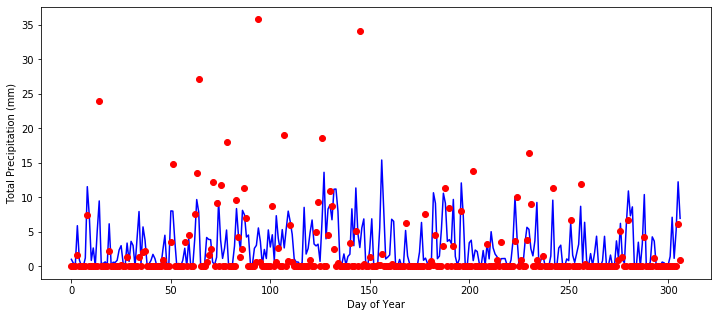

In [33]:
# Do the plot
fig, ax = plt.subplots(figsize = (12,5))
ax.plot(predictions, 'b-')
ax.plot(test_labels, 'ro')
ax.set_xlabel('Day of Year')
ax.set_ylabel('Total Precipitation (mm)')
plt.show()

In [34]:
# Get numerical feature importances
importances = list(rfprecip.feature_importances_)

# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]

# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: Avg 850hPa DWPDEP(C) Importance: 0.06
Variable: Min 925hPa DWPDEP(C) Importance: 0.06
Variable: RTOT                 Importance: 0.04
Variable: dwpc                 Importance: 0.04
Variable: pr1h                 Importance: 0.04
Variable: Avg MCLD(%)          Importance: 0.04
Variable: Avg PRES(hPa)        Importance: 0.04
Variable: Avg HCLD(%)          Importance: 0.03
Variable: Max HCLD(%)          Importance: 0.03
Variable: Min PRES(hPa)        Importance: 0.03
Variable: WMAX                 Importance: 0.02
Variable: tmpc                 Importance: 0.02
Variable: mslp                 Importance: 0.02
Variable: wspd                 Importance: 0.02
Variable: skct                 Importance: 0.02
Variable: Min 850hPa DWPDEP(C) Importance: 0.02
Variable: Max 850hPa DWPDEP(C) Importance: 0.02
Variable: Avg 925hPa DWPDEP(C) Importance: 0.02
Variable: Max 250hPa HGT(m)    Importance: 0.02
Variable: Max 850hPa TMPC      Importance: 0.02
Variable: Min 925hPa TMPC      Importanc